<a href="https://colab.research.google.com/github/nitingarg2015/EVA8/blob/master/Assignment%209/Assignment_9_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install required libraries/ packages

In [1]:

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
from torch.optim.lr_scheduler import StepLR # Import your choice of scheduler here
import albumentations as A
from albumentations.pytorch import ToTensorV2

%matplotlib inline
from torch.utils.data import DataLoader
import math


In [2]:
#install torchsummary and torch-lr-finder if required

try:
    from torchsummary import summary
except ImportError:
    !pip install torchsummary
    from torchsummary import summary

try:
    from torch_lr_finder import LRFinder, TrainDataLoaderIter, ValDataLoaderIter
except ImportError:
    !pip install torch-lr-finder
    from torch_lr_finder import LRFinder

# !pip install grad-cam

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Clone model, utility and other files from Git repository

In [3]:
!git clone  https://github.com/nitingarg2015/Refs.git

Cloning into 'Refs'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 106 (delta 55), reused 77 (delta 32), pack-reused 0
Receiving objects: 100% (106/106), 24.57 KiB | 12.29 MiB/s, done.
Resolving deltas: 100% (55/55), done.


## Import and load Resnet18 model

In [4]:
from Refs.models import basic_attention

model = basic_attention.AttnNet(in_nodes = 48, d_k = 8, dropout=0.1, no_classes=10)
model

AttentionNet(
  (conv): ConvNet(
    (conv1): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.1, inplace=False)
    )
    (conv2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.1, inplace=False)
    )
    (conv3): Sequential(
      (0): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.1, inplace=False)
    )
    (GAP): Sequential(
      (0): AvgPool2d(kernel_size=32, stride=32, padding=0)
    )
  )
  (ultimus1): Ultimus(
    (query): Linear(in_features=48, out_features=8, bias=True)
    (keys): Linear(in_features=48, out_features=8, bias=True)
    (val

In [5]:
summary(model.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
           Dropout-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           4,640
       BatchNorm2d-5           [-1, 32, 32, 32]              64
           Dropout-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 48, 32, 32]          13,872
       BatchNorm2d-8           [-1, 48, 32, 32]              96
           Dropout-9           [-1, 48, 32, 32]               0
        AvgPool2d-10             [-1, 48, 1, 1]               0
          ConvNet-11                   [-1, 48]               0
           Linear-12                    [-1, 8]             392
           Linear-13                    [-1, 8]             392
           Linear-14                   

## Load CIFAR train and test data loaders

In [6]:
#import load_CIFAR_dataloader

from Refs.utils import CIFARdata 

#set batch size
batch_size = 512

#load training dataset
classes, train_loader = CIFARdata.load_CIFAR_dataloader(train = True, transform = True, batch_size = batch_size)
#load test dataset
_, test_loader = CIFARdata.load_CIFAR_dataloader(train = False, transform = False, batch_size = batch_size)

len(train_loader), len(test_loader)

Files already downloaded and verified
Files already downloaded and verified


(98, 20)

## View sample images

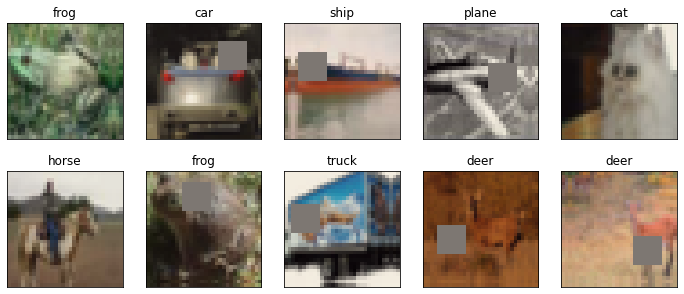

In [7]:
# get some random training images
from Refs.utils import utils

import matplotlib.pyplot as plt
images, labels = next(iter(train_loader))

no_images = 10

figure = plt.figure(figsize=(12, 5))

for index in range(1, no_images + 1):
    plt.subplot(2, 5, index)
    utils.imshow(images[index - 1])
    plt.tick_params(left=False, right=False, labelleft=False,
                    labelbottom=False, bottom=False)
    title = str(classes[labels[index - 1]])
    plt.title(title)


## Train model for 24 Epochs with CIFAR train data loader

In [8]:
from Refs import main_ass8
model = basic_attention.AttnNet(in_nodes = 48, d_k = 8, dropout=0, no_classes=10).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=0.01,
                                                steps_per_epoch=len(train_loader), 
                                                epochs=24,
                                                pct_start=0.15,
                                                div_factor=10,
                                                three_phase=False, 
                                                #final_div_factor=1000,
                                                anneal_strategy='linear'
                                                ) 

model_tr, train_losses, train_acc_all, test_losses, test_acc_all = main_ass8.fit_model(
                                                    model=model, 
                                                    device=device,
                                                    trainloader=train_loader, 
                                                    testloader=test_loader,
                                                    criterion = nn.CrossEntropyLoss(),
                                                    EPOCHS=24,
                                                    optimizer=optimizer,
                                                    scheduler=scheduler  
                                                )

EPOCH: 1 (LR: 0.001)


100%|██████████| 98/98 [00:18<00:00,  5.29it/s]



Average Training Loss=0.0044881514978408815, Accuracy=11.41
Test set: Average loss: 0.0046, Accuracy: 1323/10000 (13.23%)

EPOCH: 2 (LR: 0.0035071063104036384)


100%|██████████| 98/98 [00:10<00:00,  9.43it/s]



Average Training Loss=0.004390491323471069, Accuracy=18.512
Test set: Average loss: 0.0044, Accuracy: 2101/10000 (21.01%)

EPOCH: 3 (LR: 0.006014212620807277)


100%|██████████| 98/98 [00:10<00:00,  9.31it/s]



Average Training Loss=0.0043610356998443605, Accuracy=20.552
Test set: Average loss: 0.0044, Accuracy: 2262/10000 (22.62%)

EPOCH: 4 (LR: 0.008521318931210916)


100%|██████████| 98/98 [00:10<00:00,  9.37it/s]



Average Training Loss=0.004358986406326294, Accuracy=20.402
Test set: Average loss: 0.0045, Accuracy: 1800/10000 (18.00%)

EPOCH: 5 (LR: 0.009798921578631452)


100%|██████████| 98/98 [00:10<00:00,  9.39it/s]



Average Training Loss=0.004358104610443115, Accuracy=20.34
Test set: Average loss: 0.0044, Accuracy: 2104/10000 (21.04%)

EPOCH: 6 (LR: 0.009308730402160865)


100%|██████████| 98/98 [00:10<00:00,  9.41it/s]



Average Training Loss=0.00437151882648468, Accuracy=19.994
Test set: Average loss: 0.0045, Accuracy: 2005/10000 (20.05%)

EPOCH: 7 (LR: 0.008818539225690276)


100%|██████████| 98/98 [00:10<00:00,  9.37it/s]



Average Training Loss=0.004332685432434082, Accuracy=22.284
Test set: Average loss: 0.0044, Accuracy: 2483/10000 (24.83%)

EPOCH: 8 (LR: 0.008328348049219688)


100%|██████████| 98/98 [00:10<00:00,  9.33it/s]



Average Training Loss=0.004331445517539978, Accuracy=22.134
Test set: Average loss: 0.0044, Accuracy: 2424/10000 (24.24%)

EPOCH: 9 (LR: 0.0078381568727491)


100%|██████████| 98/98 [00:10<00:00,  9.30it/s]



Average Training Loss=0.00430399046421051, Accuracy=23.562
Test set: Average loss: 0.0044, Accuracy: 2416/10000 (24.16%)

EPOCH: 10 (LR: 0.007347965696278511)


100%|██████████| 98/98 [00:10<00:00,  9.40it/s]



Average Training Loss=0.004302052989006043, Accuracy=23.898
Test set: Average loss: 0.0044, Accuracy: 2459/10000 (24.59%)

EPOCH: 11 (LR: 0.006857774519807923)


100%|██████████| 98/98 [00:10<00:00,  9.41it/s]



Average Training Loss=0.0042963561248779295, Accuracy=23.724
Test set: Average loss: 0.0044, Accuracy: 2628/10000 (26.28%)

EPOCH: 12 (LR: 0.006367583343337335)


100%|██████████| 98/98 [00:10<00:00,  9.42it/s]



Average Training Loss=0.004283745446205139, Accuracy=24.8
Test set: Average loss: 0.0044, Accuracy: 2553/10000 (25.53%)

EPOCH: 13 (LR: 0.0058773921668667465)


100%|██████████| 98/98 [00:10<00:00,  9.41it/s]



Average Training Loss=0.004273186120986938, Accuracy=25.6
Test set: Average loss: 0.0043, Accuracy: 2660/10000 (26.60%)

EPOCH: 14 (LR: 0.005387200990396158)


100%|██████████| 98/98 [00:10<00:00,  9.33it/s]



Average Training Loss=0.0042684432125091555, Accuracy=25.688
Test set: Average loss: 0.0044, Accuracy: 2510/10000 (25.10%)

EPOCH: 15 (LR: 0.00489700981392557)


100%|██████████| 98/98 [00:10<00:00,  9.38it/s]



Average Training Loss=0.004257606825828552, Accuracy=26.722
Test set: Average loss: 0.0043, Accuracy: 2835/10000 (28.35%)

EPOCH: 16 (LR: 0.004406818637454981)


100%|██████████| 98/98 [00:10<00:00,  9.43it/s]



Average Training Loss=0.004257436475753784, Accuracy=26.64
Test set: Average loss: 0.0043, Accuracy: 2707/10000 (27.07%)

EPOCH: 17 (LR: 0.003916627460984394)


100%|██████████| 98/98 [00:10<00:00,  9.42it/s]



Average Training Loss=0.0042610632705688475, Accuracy=26.408
Test set: Average loss: 0.0043, Accuracy: 2853/10000 (28.53%)

EPOCH: 18 (LR: 0.0034264362845138046)


100%|██████████| 98/98 [00:10<00:00,  9.34it/s]



Average Training Loss=0.004248342270851135, Accuracy=27.352
Test set: Average loss: 0.0043, Accuracy: 2834/10000 (28.34%)

EPOCH: 19 (LR: 0.0029362451080432173)


100%|██████████| 98/98 [00:10<00:00,  9.39it/s]



Average Training Loss=0.004247716660499573, Accuracy=27.466
Test set: Average loss: 0.0043, Accuracy: 2900/10000 (29.00%)

EPOCH: 20 (LR: 0.002446053931572628)


100%|██████████| 98/98 [00:10<00:00,  9.32it/s]



Average Training Loss=0.004240419011116028, Accuracy=28.076
Test set: Average loss: 0.0043, Accuracy: 2913/10000 (29.13%)

EPOCH: 21 (LR: 0.001955862755102041)


100%|██████████| 98/98 [00:10<00:00,  9.39it/s]



Average Training Loss=0.0042315612888336185, Accuracy=28.486
Test set: Average loss: 0.0043, Accuracy: 2996/10000 (29.96%)

EPOCH: 22 (LR: 0.0014656715786314518)


100%|██████████| 98/98 [00:10<00:00,  9.40it/s]



Average Training Loss=0.004224748249053955, Accuracy=28.892
Test set: Average loss: 0.0043, Accuracy: 3021/10000 (30.21%)

EPOCH: 23 (LR: 0.0009754804021608627)


100%|██████████| 98/98 [00:10<00:00,  9.45it/s]



Average Training Loss=0.004221894755363464, Accuracy=29.122
Test set: Average loss: 0.0043, Accuracy: 3041/10000 (30.41%)

EPOCH: 24 (LR: 0.00048528922569027536)


100%|██████████| 98/98 [00:10<00:00,  9.42it/s]



Average Training Loss=0.004222331576347351, Accuracy=29.198
Test set: Average loss: 0.0043, Accuracy: 3063/10000 (30.63%)



## Plot training/ test Accuracy and Loss

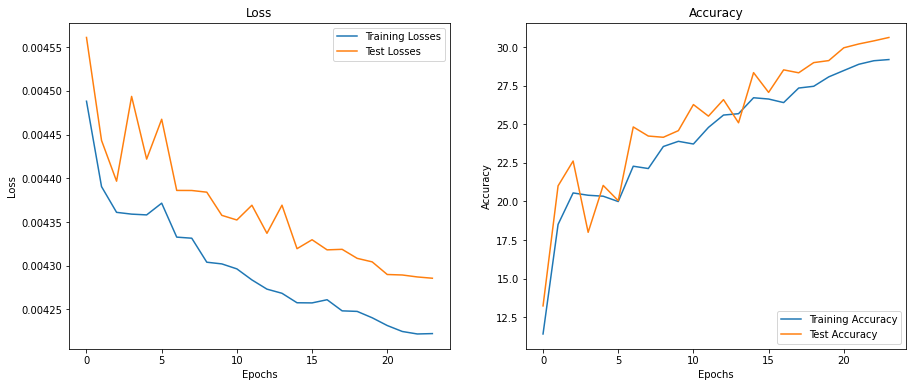

In [9]:
from Refs.utils import utils

utils.plot_LossAndAcc(train_acc_all, train_losses,test_acc_all,test_losses)

## Test Accuracy

In [10]:
from Refs import main_ass8

main_ass8.test(model, device, test_loader, criterion = nn.CrossEntropyLoss())

Test set: Average loss: 0.0043, Accuracy: 3063/10000 (30.63%)



(0.004289254927635193, 30.63)

## Retrieve data for misclassified images

In [11]:
from Refs.utils import utils

data_images, pred_labels, target_labels = utils.get_mis_classified_byloader(model, device, test_loader)
print(len(data_images), len(pred_labels), len(target_labels))

6937 6937 6937


## Plot mis classified images

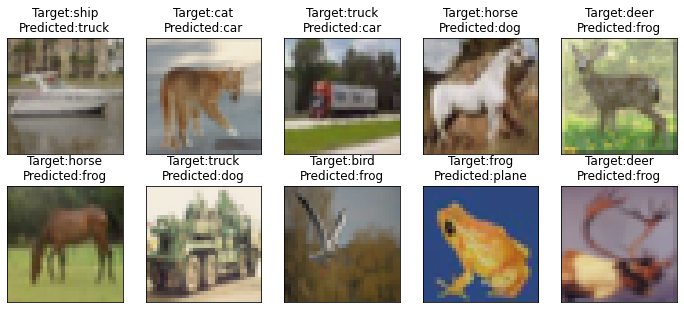

In [12]:
import matplotlib.pyplot as plt
from Refs.utils import utils
        
utils.plot_misclassified(data_images, target_labels, pred_labels, classes, no_images= 10)